In [65]:

# Google earth engine
import ee
# Authenticate and initialize Earth Engine API
#ee.Authenticate()  # Only required once
ee.Initialize(
      opt_url='https://earthengine-highvolume.googleapis.com'
)

# Built-in modules
import os
import subprocess
from pathlib import Path
import datetime
from datetime import date
from urllib.request import urlopen
from typing import Any, Optional, Tuple

# Basics of Python data handling and visualization
import math
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# Geospatial
import geemap
import geopandas as gpd
from shapely import wkt
from shapely.geometry import (
    shape,
    Point,
    LineString,
    Polygon,
    MultiPoint,
    MultiLineString,
    MultiPolygon
)
from shapely.validation import make_valid
import geojson
import folium
from geopy.distance import great_circle
from gadm import GADMDownloader
import rasterio
from rasterio import plot
import xarray as xr  # It may need Dask library https://docs.dask.org/en/stable/install.html
import rioxarray  # noqa: F401 # Its necesary for xarray.open_mfdataset() with engine `rasterio`
import osmnx as ox

# The following is not a package. It is a file utils.py which should be in the same folder as this notebook.
from utils import (
    get_adjacent_blocks, 
    get_new_adjacent_blocks,
    expand_network,
    plot_osm_base, 
    plot_block_and_adjacent
)


In [50]:
# Other 

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [51]:
# GLOBAL PARAMS:

# Country: Select one of: ["Brazil", "India", "Indonesia", "Ethiopia", "Nigeria"]
COUNTRY = "Nigeria"

# FILE PATHS (GLOBALS)
cdir = os.getcwd()
pdir = os.path.dirname(cdir)
OUTPUTS_FOLDER = os.path.join(pdir, "outputs", COUNTRY)

In [7]:
#########################################
# (1) Open sampling grid for the selected country
#########################################

file = os.path.join(OUTPUTS_FOLDER, "final_sampling_grid.geojson")
# Convert to geopandas dataframe
sampling_grid = gpd.read_file(file)
# Select only blocks in sample 
initial_sample = sampling_grid[sampling_grid['in_sample'] == 1]


Blocks adjacent to 5157: ['4974' '4975' '4976' '5156' '5158' '5338' '5339' '5340']


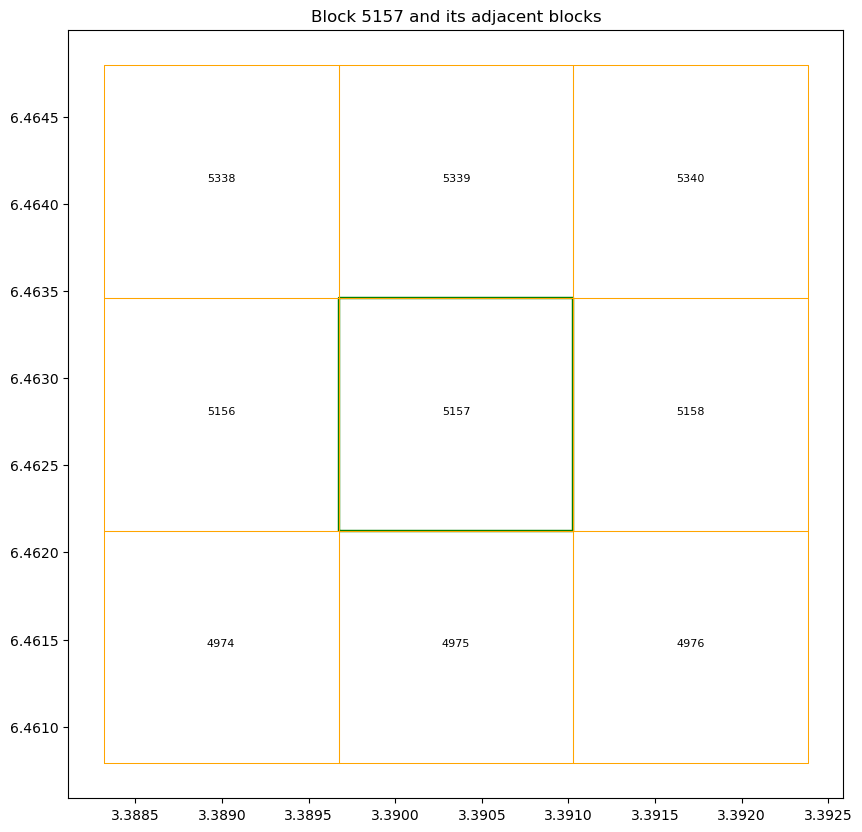

In [8]:
#########################################
# Example 1: Visualize all the adjacent blocks and block ids for a randomly selected (or user defined) block in the initial sample
#########################################

# Randomly select a single block (the origin) from the initial sample
from numpy.random import RandomState
prng = RandomState(1234567890)
origin_block_id = initial_sample.sample(n=1, random_state=prng)['block_id'].values[0]

# Return a list of all adjacent blocks to the selected block
adjacent_blocks_list = get_adjacent_blocks(origin_block_id, sampling_grid)['block_id'].values
print(f"Blocks adjacent to {origin_block_id}: {adjacent_blocks_list}")

# Plot the block and its adjacent blocks
plot_block_and_adjacent(origin_block_id, sampling_grid)



/Users/paulgubbins/Documents/Github/cfi-map2-grids-ee/notebooks/utils.py:654: FutureWarning: The `utils.config` function is deprecated and will be removed in the v2.0.0 release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(use_cache=True, log_console=True)
/Users/paulgubbins/Documents/Github/cfi-map2-grids-ee/notebooks/utils.py:657: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  bbox = gdf.buffer(0.002).total_bounds
/Users/paulgubbins/Documents/Github/cfi-map2-grids-ee/notebooks/utils.py:661: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead.
  G = ox.graph_from_bbox(*bbox, network_type='drive')
/Users/paulgubbins/Documents/Github/cfi-map2-grids-ee/no

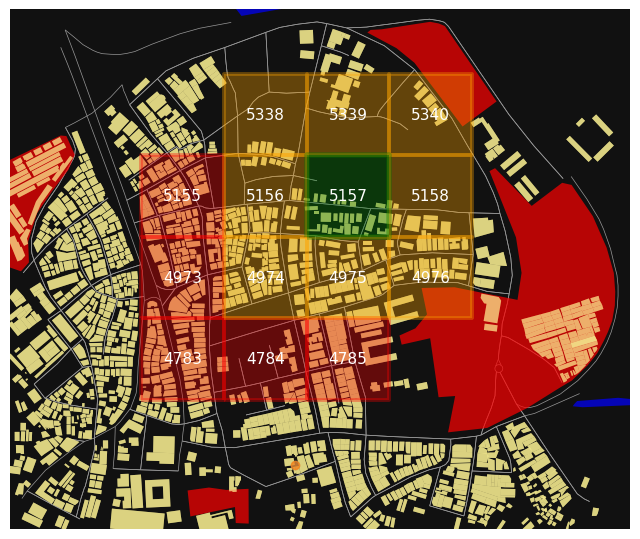

In [39]:
#########################################
# Example 2: Visualize all the adjacent blocks and block ids for two expansion 'rounds' 
#########################################

origin_gdf = sampling_grid[sampling_grid['block_id'] == origin_block_id]
adjacent_blocks_gdf = get_adjacent_blocks(origin_block_id, sampling_grid)
network = pd.concat([origin_gdf, adjacent_blocks_gdf])

edge_block_id = '4974'
new_adjacenet_blocks_gdf = get_new_adjacent_blocks(edge_block_id, network, sampling_grid)
new_network = pd.concat([network, new_adjacenet_blocks_gdf])

# Plot OSM base
plot_osm_base(new_network)
# Plot the new adjacent blocks
new_adjacenet_blocks_gdf.boundary.plot(ax=plt.gca(), color="red", linewidth = 2.75, facecolor = "red", alpha = 0.35)
# Plot the adjacent blocks
adjacent_blocks_gdf.boundary.plot(ax=plt.gca(), color="orange", linewidth = 2.75, facecolor = "orange", alpha = 0.35)
# Plot the origin block
origin_gdf.boundary.plot(ax=plt.gca(), color="green", linewidth = 4, aspect = 1, facecolor = "green", alpha = 0.55)
# Display block ids of blocks in the network
for idx, row in new_network.iterrows():
    plt.text(row.geometry.centroid.x, row.geometry.centroid.y, row['block_id'], fontsize=11, color = "black", ha='center', va='center')



In [11]:
####################################################################
# Example 2: VISUALIZE NETWORK OVER INTERACTIVE MAP
###################################################################

# Converting assets to ee objects
origin_ee = geemap.gdf_to_ee(origin_gdf)
adjacent_blocks_ee = geemap.gdf_to_ee(adjacent_blocks_gdf)
new_adjacenet_blocks_ee = geemap.gdf_to_ee(new_adjacenet_blocks_gdf)
network_ee = geemap.gdf_to_ee(new_network)

m = geemap.Map()
m.centerObject(network_ee, 16)

# Add origin block to the map
m.add_layer(origin_ee, {'color': 'green', "width": 2}, "Origin block")
# Add first round expansion to map
m.add_layer(adjacent_blocks_ee, {'color': 'orange', "width": 2}, "1st expansion")
# Add second round expansion to map
m.add_layer(new_adjacenet_blocks_ee, {'color': 'red', "width": 2}, "2nd expansion")

m

Map(center=[6.462125498222141, 3.3896724977096016], controls=(WidgetControl(options=['position', 'transparent_…

In [67]:
##############################################
# Example 3: Program that dynamically creates a network from a single block based on user input
##############################################

# Randomly select a single block (the origin) from the initial sample
origin_block_id = initial_sample.sample(n=1, random_state=prng)['block_id'].values[0]

# Expand the network dynamically
final_network_gdf = expand_network(origin_block_id, sampling_grid)


Starting network expansion from block ID (origin):  2031
New edge blocks for round 1:  ['1883', '1884', '1885', '2030', '2032', '2181', '2182']
New edge blocks for round 2:  ['1738', '1739', '1740', '1886']
New edge blocks for round 3:  ['1586', '1587', '1588', '1737', '1741']
Final network consists of block IDs:  ['2031', '1883', '1884', '1885', '2030', '2032', '2181', '2182', '1738', '1739', '1740', '1886', '1586', '1587', '1588', '1737', '1741']
Round information: 
    block_id round
0      2031     0
1      1883     1
2      1884     1
3      1885     1
4      2030     1
5      2032     1
6      2181     1
7      2182     1
8      1738     2
9      1739     2
10     1740     2
11     1886     2
12     1586     3
13     1587     3
14     1588     3
15     1737     3
16     1741     3


In [42]:
####################################################################
# Example 3: Visualize the final network over an interactive map
###################################################################

# Converting assets to ee objects
network_ee = geemap.gdf_to_ee(final_network_gdf)

m = geemap.Map()
m.centerObject(network_ee, 16)

########################
# BLOCK NETWORK
########################

# Return list of unique round values in final_network_gdf
unique_rounds = final_network_gdf['round'].unique().tolist()

# Create a list of hex colors for each round
palette = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6']
colors = palette[:len(unique_rounds)]

styled_network = geemap.ee_vector_style(
    network_ee, column='round', labels=unique_rounds, fillColor=colors, width = 2
)

# Add origin block to the map
m.add_layer(styled_network, {}, "Network")
m.add_labels(
data=network_ee,
column="block_id",
font_size="10pt",
font_color="black",
font_family="arial",
font_weight="plain",
draggable = False
)

m

Map(center=[6.460846630212338, 3.425562785008051], controls=(WidgetControl(options=['position', 'transparent_b…

/Users/paulgubbins/Documents/Github/cfi-map2-grids-ee/notebooks/utils.py:654: FutureWarning: The `utils.config` function is deprecated and will be removed in the v2.0.0 release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(use_cache=True, log_console=True)
/Users/paulgubbins/Documents/Github/cfi-map2-grids-ee/notebooks/utils.py:659: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  bbox = perim.buffer(0.004).bounds


(6.446091000000624, 6.431412999996291, 3.418076999999757, 3.403298000000544)


/var/folders/r2/wkhyv2tx5g7gmy_bw0rgxp7w0000gn/T/ipykernel_66628/4104684990.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(final_network_gdf.centroid.x, final_network_gdf.centroid.y, final_network_gdf['block_id']):


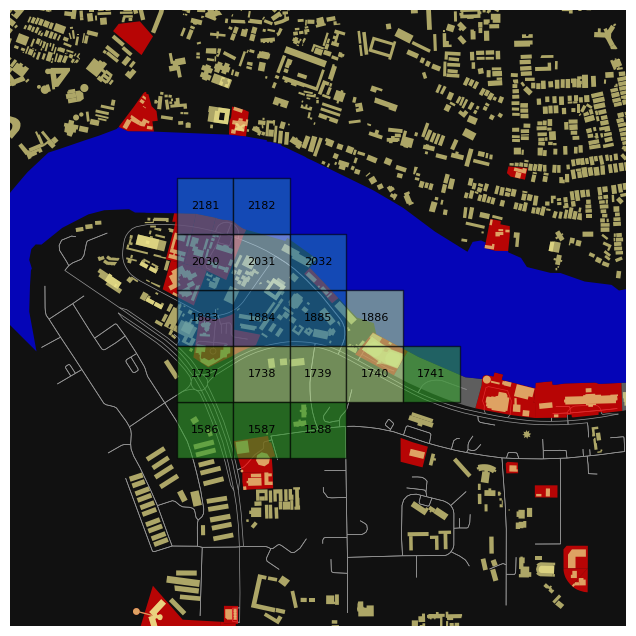

In [75]:
####################################################################
# Example 3: Visualize the final network over an static map
###################################################################

plot_osm_base(final_network_gdf)

# For each group of blocks in gdf defined by the column "round", use a different color
for round, group in final_network_gdf.groupby('round'):
    group.plot(ax=plt.gca(), facecolor=colors[unique_rounds.index(round)], edgecolor = 'black', linewidth=1, alpha = 0.6)

# Display block ids at center of each block: 
for x, y, label in zip(final_network_gdf.centroid.x, final_network_gdf.centroid.y, final_network_gdf['block_id']):
    plt.text(x, y, label, fontsize=8, ha='center', va='center')

# Save plot
plt.savefig(os.path.join(OUTPUTS_FOLDER, "example_network.png"), dpi=300)
